In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import mysql.connector
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
from shapely.ops import nearest_points
from shapely.wkt import loads
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
import mysql.connector


In [2]:

cnx = mysql.connector.connect(user='spirz', 
                              password='this_is_my_PASSWORD_m8',
                              host='localhost',
                              database='dem_from_contours_lines',
                              autocommit=True)
cursor = cnx.cursor(buffered=True,dictionary=True)
contours_lines_table_name='contours_lines'
###
tree_edges_table_name="tree_edges"
####
osm_nodes_table_name="osm_nodes"
osm_edges_table_name="osm_edges"
intersections_table_name="intersections"
2

2

In [3]:
t1=time.time()
place_name='Corse, France'
G_osm=ox.graph_from_place(place_name,network_type='drive')

t2=time.time()
print(t2-t1)
len(G_osm.nodes()),len(G_osm.edges())

52.07447838783264


(17435, 37758)

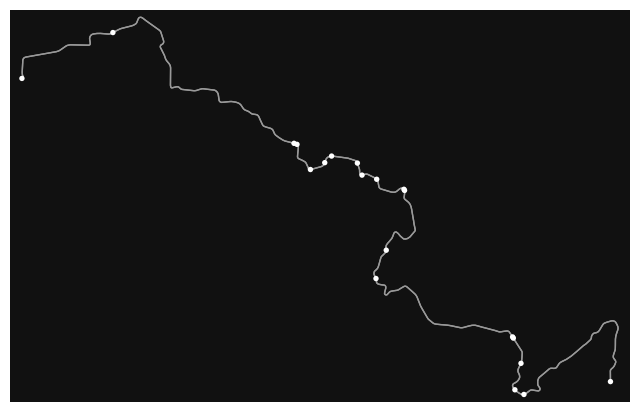

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [4]:
lat_1,lon_1=42.583253, 8.831825
lat_2,lon_2=42.543587, 8.931477
node_1,node_2=ox.nearest_nodes(G_osm,[lon_1,lon_2],[lat_1,lat_2])
path=nx.shortest_path(G_osm,node_1,node_2,weight='length')
ox.plot_graph(nx.subgraph(G_osm,path))

In [5]:
edge_coordinates,elevations,nodes_coordinates,nodes_elevations=[],[],[],[]
total_length=0
for k in range(len(path)-1):
    cmd="SELECT elevation FROM %s WHERE osm_id=%i"%(osm_nodes_table_name,path[k])
    cursor.execute(cmd)
    elevation=cursor.fetchone()['elevation']
    if elevation is not None:
        print(path[k])
        elevations.append(elevation)
        edge_coordinates.append(total_length)
        nodes_elevations.append(elevation)
        nodes_coordinates.append(total_length)
    length=G_osm.get_edge_data(path[k],path[k+1],0)['length']
    cmd="SELECT elevation,edge_coordinate FROM %s WHERE osm_begin=%i AND osm_end=%i AND osm_key=0"%(intersections_table_name,path[k],path[k+1])
    cursor.execute(cmd)
    output=cursor.fetchall()
    if len(output)>0:
        output=sorted(output,key=lambda elem:elem['edge_coordinate'])
        edge_coordinates+=[total_length+elem['edge_coordinate'] for elem in output]
        elevations+=[elem['elevation'] for elem in output]
    else:
        cmd="SELECT elevation,edge_coordinate FROM %s WHERE osm_begin=%i AND osm_end=%i AND osm_key=0"%(intersections_table_name,path[k+1],path[k])
        cursor.execute(cmd)
        output=cursor.fetchall()
        if len(output)>0:
            output=sorted(output,key=lambda elem:-elem['edge_coordinate'])
            edge_coordinates+=[total_length+length-elem['edge_coordinate'] for elem in output]
            elevations+=[elem['elevation'] for elem in output]
    total_length+=length
cmd="SELECT elevation FROM %s WHERE osm_id=%i"%(osm_nodes_table_name,path[-1])
cursor.execute(cmd)
elevation=cursor.fetchone()['elevation']
if elevation is not None:
    elevations.append(elevation)
    edge_coordinates.append(total_length)
    nodes_elevations.append(elevation)
    nodes_coordinates.append(total_length)

9057415420
439743430
82580469
4345494465
82580433
9051943848
6341595005
9051943798
340364201


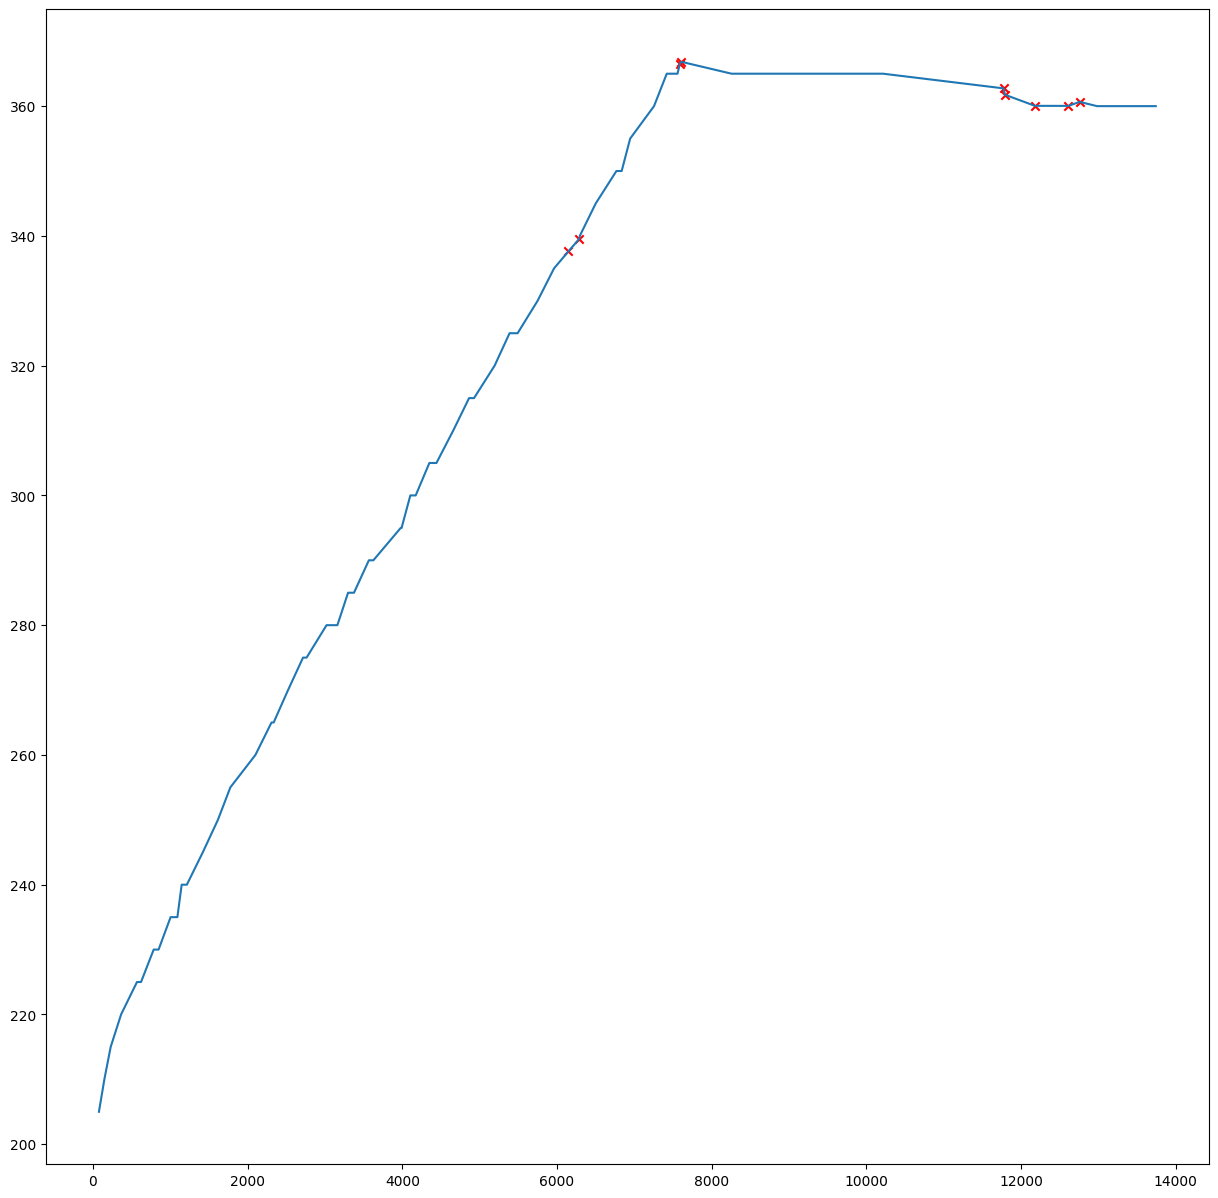

In [6]:
plt.rcParams['figure.figsize']=(15,15)
plt.plot(edge_coordinates,elevations)
plt.scatter(nodes_coordinates,nodes_elevations,marker='x',c='r')